### Chapter 4.4 
# Retrial Model

---
>(c) Tobias Hossfeld  (Aug 2021)<br><br>
> This script and the figures are part of the following book. The book is to be cited whenever the script is used (copyright CC BY-SA 4.0):<br>
> *Tran-Gia, P. & Hossfeld, T. (2021). 
Performance Modeling and Analysis of Communication Networks - A Lecture Note.
Würzburg University Press.*
> *https://doi.org/10.25972/WUP-978-3-95826-153-2*

---

In communication networks, especially for systems operating in loss mode, rejected customer requests sooner or later lead to new attempts - this happens rather sooner. Especially when looking at systems with a finite number of sources, this effect has a significant impact on the overall range of traffic and on the performance of the system.
We are looking at an extension of the loss system with finite number of sources (Engset model), to a more realistic model considering this retrial or repeated-attempt modeling approach. 

A detailed description of the customer retrial model is provided in Chapter 4.4. This script provides an implementation of the  analysis in which a two-dimensional Markov state process is used and solved with a recursive algorithm. 

The script maps the two-dimensional Markov states $[X=i,Z=j]$ to a single dimension using the function `c2i(i,j)` (and `vec2matrix` as inverse mapping). This allows to use the previously implemented methods for analyzing a continuous-time Markov chain.

In [1]:
import numpy as np
    
#%% Index helper functions
def c2i(i, j, n=2, m=3):
    assert 0 <= i <= n , "Argument 'i' out of range"
    assert 0 <= j <= m , "Argument 'j' out of range"
    assert 0 <= i+j <= m, "i+j >m"
    return j if i==0 else int(i*m-(i-1)*i/2+j+i)
 
def vec2matrix(X2, n, m):
    mat = np.zeros((n+1,m+1))
    last = 0
    for i in np.arange(n+1):
        #print(f'{i}. {m-i} last={last}')
        mat[i,:m-i+1]=X2[last:last+m-i+1]
        last += m-i+1
    return mat

## Transition Rate Matrix

The rate transition matrix is defined now `rateMatrix()`. Thereby, we consider the transitions $[X=i_0,Z=j_0] \to [X=i_1,Z=j_1]$. The two-dimensional index is mapped to an one-dimensional index with the mapping helper functions above. 

The function `printMatrix` provides a visualization of the matrix.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def printMatrix(Q):
    print(pd.DataFrame(Q)) # pretty display of the matrix using Pandas    
    Q2 = Q.copy()
    Q2[Q==0]=np.nan
    plt.figure(4, clear=True)
    plt.matshow(Q2,fignum=4, cmap='Blues')
    
def rateMatrix(n=5, m=8, alpha0=13.2, alpha=2.1, mu=3.5, theta=0.8):
    entries = int((n+1)*(m+1-n/2))#(n+1)*(m+1)
    Q = np.zeros( (entries, entries) ) # rate matrix
    for i in range(n+1):
        for j in range(m+1):        
            #print(f'({i},{j})')
            # only outgoing connections
            if i<n:
                if i>0 and i+j<=m: Q[ c2i(i,j,n,m), c2i(i-1,j,n,m) ] = i*mu
                if j>0 and i+j<=m: Q[ c2i(i,j,n,m), c2i(i+1,j-1,n,m) ] = j*alpha0        
                if i+j<m: Q[ c2i(i,j,n,m), c2i(i+1,j,n,m) ] = (m-i-j)*alpha
            else: #i==n
                if j<=m-n: Q[ c2i(n,j,n,m), c2i(n-1,j,n,m) ] = n*mu
                if j<m-n: Q[ c2i(n,j,n,m), c2i(n,j+1,n,m) ] = (m-n-j)*theta*alpha
                if j>0 and j<=m-n: Q[ c2i(n,j,n,m), c2i(n,j-1,n,m) ] = (j)*alpha0*(1-theta)
    
    # set the diagonal
    qi = -Q.sum(axis = 1)
    np.fill_diagonal(Q,qi) # set diagonal values
    return Q


## Example: Parameter Setting 
A particular system and its parameter is considered. The corresponding rate matrix is plotted.

          0         1         2    3         4         5         6         7  \
0 -0.021667  0.000000  0.000000  0.0  0.021667  0.000000  0.000000  0.000000   
1  0.000000 -0.181111  0.000000  0.0  0.166667  0.014444  0.000000  0.000000   
2  0.000000  0.000000 -0.340556  0.0  0.000000  0.333333  0.007222  0.000000   
3  0.000000  0.000000  0.000000 -0.5  0.000000  0.000000  0.500000  0.000000   
4  0.008333  0.000000  0.000000  0.0 -0.022778  0.000000  0.000000  0.014444   
5  0.000000  0.008333  0.000000  0.0  0.000000 -0.182222  0.000000  0.166667   
6  0.000000  0.000000  0.008333  0.0  0.000000  0.000000 -0.341667  0.000000   
7  0.000000  0.000000  0.000000  0.0  0.016667  0.000000  0.000000 -0.022444   
8  0.000000  0.000000  0.000000  0.0  0.000000  0.016667  0.000000  0.033333   

          8  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.000000  
5  0.007222  
6  0.333333  
7  0.005778  
8 -0.050000  


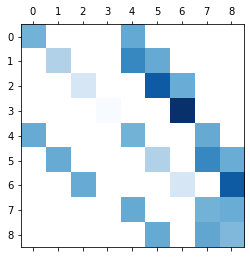

In [4]:
#%% Parameter
n = 2 # number of servers
m = 3 # number of customers (finite populatoin)

EB = 120 # mean service time
mu = 1.0/EB # service rate

ER=6 # mean time in wait-for-retrial state
alpha0 = 1.0/ER # corresponding rate

theta = 0.8 # retrial probability

rho = 1.3 # normalized offered load
alpha = rho*mu*n/m # offered load per customer

# the transition rate matrix
Q = rateMatrix(n,m,alpha0,alpha,mu,theta)    
printMatrix(Q)        

## Solve the Steady State Equation System
The steady state equation system needs to be solved (as in the one-dimensional case):

$ X \cdot Q = 0$ and $X \cdot e = 1$

Alternatively, the recursion algorithm in the book in Chapter 4.4 can be implemented.

In [5]:
from scipy import linalg

#%% Solve this system
def steadyState(Q,n=5,m=8):    
    Q2 = Q.copy()
    b = np.zeros(len(Q))
    b[-1] = 1
    Q2[:, -1] = 1
    #print(Q2)
    X = np.matmul(b, linalg.inv(Q2)) # matrix inverse
    
    return vec2matrix(X,n,m)# X.reshape((n+1,m-n+1))

X = steadyState(Q,n,m)

## Calculation of Traffic Flows 
To calculate system characteristics, we determine the rates of traffic processes in the model: 

The indices of the traffic flows are defined as follows.
* $F$: fresh call, first attempt
* $R$: retrial, repeated call
* $S$: successful call, completed call
* $U$: unsuccessful call or blocked call which will be repeated
* $B$: unsuccessful call or blocked call which is abandoned

According to this indexing scheme, $\lambda_{FS}$ is e.g. the rate (in calls per unit of time) of fresh calls that are accepted and immediately served.

A characteristic performance measure for the retrial effect is the average number of calls -- including the initiating fresh calls -- that a call has to make

$ \displaystyle
\eta = \frac{\lambda_{R}+\lambda_{F}}{\lambda_F} = 1 + \frac{\lambda_R}{\lambda_F}
$

The blocking probability experienced by a user initiating a fresh call is given as

$ \displaystyle
p_{B_F} = \frac{\lambda_{FU}+\lambda_{FB}}{\lambda_F}
$


In [7]:
# Traffic flow analysis based on steady state distribution X
def KPIs_state(X,n,m,alpha,alpha0,theta):    
    lamFS = 0
    for i in range(n):
        j = np.arange(m-n+1)
        lamFS += np.sum( (m-i-j)*X[i,j] )
    lamFS *= alpha
        
    j = np.arange(m-n+1)
    tmp = alpha*np.sum( (m-n-j)*X[n,j] )
    
    lamFU = theta*tmp
    lamFB = (1-theta)*tmp
        
    pB =  (lamFU+lamFB)/(lamFS+lamFU+lamFB)
    
    lamRS = 0
    for i in range(n):
        j = np.arange(m-n+1)
        lamRS += np.sum( j*X[i,j] )
    lamRS *= alpha0
        
    j = np.arange(m-n+1)
    tmp2 = alpha0*np.sum( j*X[n,j] )
    
    lamRU = theta*tmp2
    lamRB = (1-theta)*tmp2
    
    eta = 1 + (lamRS+lamRU+lamRB) / (lamFS+lamFU+lamFB)
    
    pball = 1-(lamRS + lamFS)/(lamRS+lamRU+lamRB + lamFS+lamFU+lamFB)        
        
    return (pB, eta, pball)

# KPIs are derived for a parameter set. 
# First, the rate matrix is defined. 
# Then the steady state probabilities are computed.
# Finally, the KPIs are calculated.
def KPIs(n,m,alpha,alpha0,theta,mu):    
    Q = rateMatrix(n,m,alpha0,alpha,mu,theta)   
    X = steadyState(Q,n,m)
    return KPIs_state(X,n,m,alpha,alpha0,theta)  

# This is jut a wrapper function to loop over the vector 'alpha'
def KPIs_wrapper(n,m,alpha,alpha0,theta,mu):    
    if np.isscalar(alpha):
        return KPIs(n,m,alpha,alpha0,theta,mu)
    else:
        pB = np.zeros_like(alpha)
        eta = np.zeros_like(alpha)
        pball = np.zeros_like(alpha)        
        for i, al in enumerate(alpha):
            pB[i], eta[i], pball[i] = KPIs(n,m,al,alpha0,theta,mu)
    return (pB, eta, pball )

## Parameter Study
A parameter sensitivity study is conducted by varying the retrial probability $\Theta$ and the offered load of idle customers.

*Note: It will take some time until the computation is done.*

In [10]:
# Parameter settings
m = 100
n = 15
EB = 120
mu = 1.0/EB

alpha0 = 20*mu

rho0 = np.linspace(0.4,2,100) # lam = alpha*m
thetas = [0.5, 0.8, 0.9, 1.0]

# initialize the result matrices
pBs = np.zeros((len(thetas), len(rho0))) # blocking probability of fresh calls
etas = np.zeros((len(thetas), len(rho0))) # average number of calls (incl. the initiating fresh call) that a call has to make
pball = np.zeros((len(thetas), len(rho0))) # blocking probability of all calls

# compute the KPIs
print('computation is started...')
for k, theta in enumerate(thetas):
    print(f'theta={theta}')
    alpha = rho0*mu*n/m
    pBs[k,:], etas[k,:], pball[k,:] = KPIs_wrapper(n,m,alpha,alpha0,theta,mu)    
print('...done!')    

computation is started...
theta=0.5
theta=0.8
theta=0.9
theta=1.0
...done!


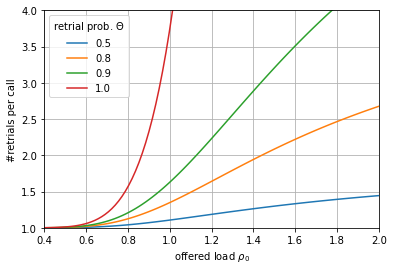

In [11]:
for k, theta in enumerate(thetas):                     
    plt.plot(rho0,  etas[k,:], '-', label=theta, )
    
plt.xlabel('offered load $\\rho_0$')
plt.ylabel('#retrials per call')
plt.grid(which='major')
plt.xlim([0.4, rho0[-1]])
#plt.yscale('log')
plt.ylim([1, 4])
plt.legend(title='retrial prob. $\\Theta$');